In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('position_output.csv')

In [3]:
df[df['ID']==0].shape[0]

167046

In [25]:
df

,ID,t_step,pos_x,pos_y,pos_z
0,0,0,-15.221469,22.104223,-7.943686
1,1,0,-18.052212,-44.466942,-13.693184
2,2,0,27.849342,-38.792019,4.903335
3,3,0,-2.778227,4.906150,7.191817
4,4,0,10.153835,-19.482559,32.767376
...,...,...,...,...,...
1274995,250,499900,-10.787306,12.350640,-3.033815
1274996,251,499900,-30.770641,-9.681119,2.371442
1274997,252,499900,-0.048191,3.121089,-6.976157
1274998,253,499900,-7.323294,7.857467,6.388738


In [4]:
N = df['ID'].max()+1

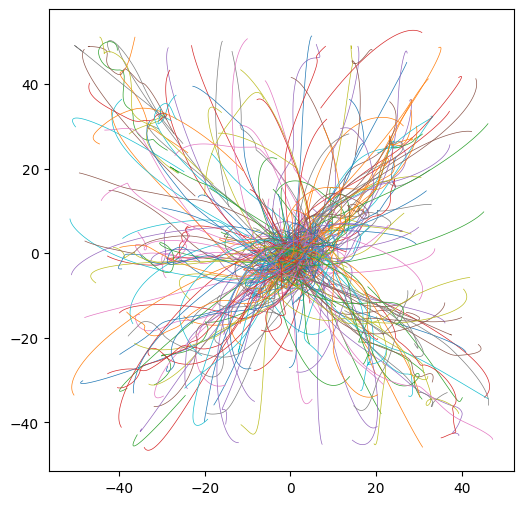

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

for i in range(N):
    ax.plot(df[df['ID']==i]['pos_x'][::2000], df[df['ID']==i]['pos_y'][::2000], linewidth=0.5)

# ax.set_xlim(-50,50)
# ax.set_ylim(-30,30)

plt.show()

In [ ]:
import matplotlib.animation as animation
from matplotlib.pyplot import cm

# Create figure and axis
fig, ax = plt.subplots(figsize=(6,6))
color = cm.rainbow(np.linspace(0, 1, N))

# Set axis limits based on previous plot
# ax.set_xlim(-100,50)
# ax.set_ylim(-100,100)

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)

    current_step = frame * 20

    for i, c in enumerate(color):
        current_data = df[(df['t_step'] == current_step) & (df['ID'] == i)]
        ax.scatter(current_data['pos_x'], current_data['pos_y'], s=10, color=c)

# Create animation
max_steps = df[df['ID']==0]['t_step'].max()
frames = max_steps // 20
ani = animation.FuncAnimation(fig, update, frames=frames, interval=50)

# Save as gif
ani.save('movement.gif', writer='pillow')
plt.close()